# **BASELINE SHOWS HOW TO AGGREGATE TRAIN DATA AND MAKE SIMPLE CONSTANT PREDICTIONS FOR EACH CUSTOMER**

**Hardware**:
- CPU model: 12th Gen Intel(R) Core(TM) i5-12400
- 32 GB RAM (DDR5)
- GPU has not been used

**Note**: computation time for long-running cells is specified for the current hardware!

In [1]:
import gc
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
calendar = pd.read_csv('data/external/calendar_extended.csv')
calendar['date'] = pd.to_datetime(calendar['date'])
calendar

,date,week,part
0,2022-07-25,0,train
1,2022-07-26,0,train
2,2022-07-27,0,train
3,2022-07-28,0,train
4,2022-07-29,0,train
...,...,...,...
905,2025-01-15,129,private
906,2025-01-16,129,private
907,2025-01-17,129,private
908,2025-01-18,129,private


In [3]:
# Run time ~ 1m 30s
transactions = None
for i in tqdm(range(1, 5 + 1)):
    gc.collect()
    if isinstance(transactions, type(None)):
        transactions = pd.read_parquet(f'data/external/transactions_{i}.parquet')
        transactions = transactions[transactions['doc_payer_bank_name_flag'] == 1]
        transactions['doc_payer_inn'] = transactions['doc_payer_inn'].apply(lambda x: x[3:]).astype(int)
        transactions['doc_payee_inn'] = transactions['doc_payee_inn'].apply(lambda x: x[3:]).astype(int)
    else:
        transactions_ = pd.read_parquet(f'data/external/transactions_{i}.parquet')
        transactions_ = transactions_[transactions_['doc_payer_bank_name_flag'] == 1]
        transactions_['doc_payer_inn'] = transactions_['doc_payer_inn'].apply(lambda x: x[3:]).astype(int)
        transactions_['doc_payee_inn'] = transactions_['doc_payee_inn'].apply(lambda x: x[3:]).astype(int)
        transactions = pd.concat([transactions, transactions_], axis=0)
    gc.collect()
transactions = transactions.reset_index(drop=True)
del transactions_
gc.collect()
transactions

100%|██████████| 5/5 [01:25<00:00, 17.07s/it]


,date,doc_payer_inn,doc_payee_inn,trns_count,trns_amount,doc_payer_bank_name_encoded,doc_payee_bank_name_encoded,doc_payer_bank_name_flag,doc_payee_bank_name_flag,trns_class_encoded
0,2022-07-25 00:00:00+00:00,1000007,3671152,1.0,65274.714844,51,3343,1,0,45
1,2022-07-25 00:00:00+00:00,1000051,5082671,1.0,380510.625000,51,51,1,1,38
2,2022-07-25 00:00:00+00:00,1000191,19649,1.0,104022.640625,51,3198,1,0,45
3,2022-07-25 00:00:00+00:00,1000303,2499462,1.0,13476.793945,51,3343,1,0,45
4,2022-07-25 00:00:00+00:00,1000314,1129382,1.0,3011.298584,51,1675,1,0,45
...,...,...,...,...,...,...,...,...,...,...
126564318,2024-10-26 00:00:00+00:00,998749,5202918,4.0,415910.750000,51,3343,1,0,45
126564319,2024-10-26 00:00:00+00:00,999307,4169209,1.0,3278.137939,51,51,1,1,36
126564320,2024-10-26 00:00:00+00:00,999759,3767637,4.0,105530.812500,51,3343,1,0,45
126564321,2024-10-26 00:00:00+00:00,999825,4481182,4.0,6693.479004,51,5469,1,0,45


In [4]:
# Run time ~ 9s
transactions['date'] = transactions['date'].dt.tz_localize(None)
df = pd.merge(left=transactions, right=calendar, how='left', on='date')
del transactions, calendar
gc.collect()
df

,date,doc_payer_inn,doc_payee_inn,trns_count,trns_amount,doc_payer_bank_name_encoded,doc_payee_bank_name_encoded,doc_payer_bank_name_flag,doc_payee_bank_name_flag,trns_class_encoded,week,part
0,2022-07-25,1000007,3671152,1.0,65274.714844,51,3343,1,0,45,0,train
1,2022-07-25,1000051,5082671,1.0,380510.625000,51,51,1,1,38,0,train
2,2022-07-25,1000191,19649,1.0,104022.640625,51,3198,1,0,45,0,train
3,2022-07-25,1000303,2499462,1.0,13476.793945,51,3343,1,0,45,0,train
4,2022-07-25,1000314,1129382,1.0,3011.298584,51,1675,1,0,45,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...
126564318,2024-10-26,998749,5202918,4.0,415910.750000,51,3343,1,0,45,117,validation_private
126564319,2024-10-26,999307,4169209,1.0,3278.137939,51,51,1,1,36,117,validation_private
126564320,2024-10-26,999759,3767637,4.0,105530.812500,51,3343,1,0,45,117,validation_private
126564321,2024-10-26,999825,4481182,4.0,6693.479004,51,5469,1,0,45,117,validation_private


In [5]:
# Run time ~ 9s
df['inn_id'] = df['doc_payer_inn']
df['part'] = df['part'].map({'train': 0, 'validation_private': 1, 'validation_public': 2})
df = df.drop(columns=['date', 'doc_payer_inn', 'doc_payee_inn',
                      'doc_payer_bank_name_encoded', 'doc_payee_bank_name_encoded',
                      'trns_class_encoded'], axis=1)
gc.collect()
df

,trns_count,trns_amount,doc_payer_bank_name_flag,doc_payee_bank_name_flag,week,part,inn_id
0,1.0,65274.714844,1,0,0,0,1000007
1,1.0,380510.625000,1,1,0,0,1000051
2,1.0,104022.640625,1,0,0,0,1000191
3,1.0,13476.793945,1,0,0,0,1000303
4,1.0,3011.298584,1,0,0,0,1000314
...,...,...,...,...,...,...,...
126564318,4.0,415910.750000,1,0,117,1,998749
126564319,1.0,3278.137939,1,1,117,1,999307
126564320,4.0,105530.812500,1,0,117,1,999759
126564321,4.0,6693.479004,1,0,117,1,999825


In [6]:
# Run time ~ 2m 40s
df.to_csv('tmp.csv', index=False)
del df
gc.collect()

0

In [7]:
0 / 0
# RESTART THE KERNEL AND START EXECUTING CELLS BELOW, THAT IS MADE TO CLEAN RAM

ZeroDivisionError: division by zero

In [1]:
import gc
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Run time ~ 30s
df = pd.read_csv('tmp.csv')
df

,trns_count,trns_amount,doc_payer_bank_name_flag,doc_payee_bank_name_flag,week,part,inn_id
0,1.0,65274.714844,1,0,0,0,1000007
1,1.0,380510.625000,1,1,0,0,1000051
2,1.0,104022.640625,1,0,0,0,1000191
3,1.0,13476.793945,1,0,0,0,1000303
4,1.0,3011.298584,1,0,0,0,1000314
...,...,...,...,...,...,...,...
126564318,4.0,415910.750000,1,0,117,1,998749
126564319,1.0,3278.137939,1,1,117,1,999307
126564320,4.0,105530.812500,1,0,117,1,999759
126564321,4.0,6693.479004,1,0,117,1,999825


In [3]:
# Run time ~ 30s
df = df.groupby(['inn_id', 'week'], as_index=False)[['trns_count',
                                                     'trns_amount',
                                                     'doc_payee_bank_name_flag',
                                                     'part',]].agg({'trns_count': 'sum',
                                                                    'trns_amount': 'sum',
                                                                    'doc_payee_bank_name_flag': 'mean',
                                                                    'part': 'first'})
df

,inn_id,week,trns_count,trns_amount,doc_payee_bank_name_flag,part
0,4,0,1.0,71151.390625,0.0,0
1,4,1,1.0,49954.191406,0.0,0
2,4,3,1.0,160490.203125,0.0,0
3,4,5,1.0,127545.695312,0.0,0
4,4,7,1.0,30807.445312,0.0,0
...,...,...,...,...,...,...
37081973,5265325,39,2.0,84679.210938,0.0,0
37081974,5265325,40,1.0,37962.019531,0.0,0
37081975,5265325,42,1.0,42333.054688,0.0,0
37081976,5265325,77,1.0,54005.535156,0.0,0


<Axes: xlabel='trns_amount', ylabel='Count'>

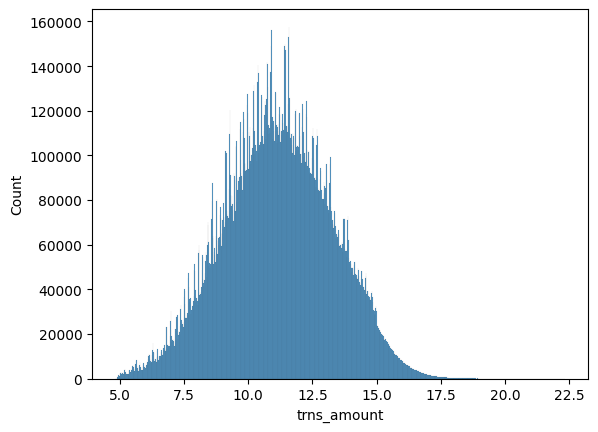

In [4]:
# Run time ~ 15s
sns.histplot(np.log1p(df['trns_amount']))

In [5]:
df['inn_id'].value_counts()

inn_id
2803100    118
3484993    118
4783270    118
5186623    118
4115914    118
          ... 
1787379      1
197468       1
1787398      1
3958667      1
5265326      1
Name: count, Length: 2040098, dtype: int64

In [6]:
submission = pd.read_csv('data/external/sample_submit_extended.csv')
sub_cols = submission.columns
submission['inn_id_'] = submission['inn_id'].apply(lambda x: x[3:]).astype(int)
submission['inn_id'], submission['inn_id_'] = submission['inn_id_'], submission['inn_id']
submission

,inn_id,week,predict,inn_id_
0,1000051,118,59851.0,inn1000051
1,1000051,119,59851.0,inn1000051
2,1000051,120,59851.0,inn1000051
3,1000051,121,59851.0,inn1000051
4,1000051,122,59851.0,inn1000051
...,...,...,...,...
623551,999886,125,7668105.0,inn999886
623552,999886,126,7668105.0,inn999886
623553,999886,127,7668105.0,inn999886
623554,999886,128,7668105.0,inn999886


In [7]:
df['log_trns_amount'] = np.log1p(df['trns_amount'])
df_solver = df.groupby('inn_id', as_index=False)[['log_trns_amount']].agg('mean')
df_solver['exp_mean_log_target'] = np.exp(df_solver['log_trns_amount']) - 1
df_solver

,inn_id,log_trns_amount,exp_mean_log_target
0,4,10.933415,56016.254329
1,10,11.125376,67870.820312
2,12,10.335394,30802.833984
3,13,10.985360,59002.968181
4,15,9.335103,11327.793422
...,...,...,...
2040093,5265309,9.873438,19406.956194
2040094,5265312,11.261735,77786.428540
2040095,5265314,12.754222,346008.720474
2040096,5265325,11.023816,61316.238898


In [8]:
submission = pd.merge(left=submission, right=df_solver[['inn_id', 'exp_mean_log_target']], how='left', on='inn_id')
submission

,inn_id,week,predict,inn_id_,exp_mean_log_target
0,1000051,118,59851.0,inn1000051,1.222779e+05
1,1000051,119,59851.0,inn1000051,1.222779e+05
2,1000051,120,59851.0,inn1000051,1.222779e+05
3,1000051,121,59851.0,inn1000051,1.222779e+05
4,1000051,122,59851.0,inn1000051,1.222779e+05
...,...,...,...,...,...
623551,999886,125,7668105.0,inn999886,6.290576e+06
623552,999886,126,7668105.0,inn999886,6.290576e+06
623553,999886,127,7668105.0,inn999886,6.290576e+06
623554,999886,128,7668105.0,inn999886,6.290576e+06


In [9]:
submission['exp_mean_log_target'].isna().any(), (submission['exp_mean_log_target'] <= 0).any()

(False, False)

In [10]:
submission = submission[['inn_id_', 'week', 'exp_mean_log_target']]
submission.columns = sub_cols
submission

,inn_id,week,predict
0,inn1000051,118,1.222779e+05
1,inn1000051,119,1.222779e+05
2,inn1000051,120,1.222779e+05
3,inn1000051,121,1.222779e+05
4,inn1000051,122,1.222779e+05
...,...,...,...
623551,inn999886,125,6.290576e+06
623552,inn999886,126,6.290576e+06
623553,inn999886,127,6.290576e+06
623554,inn999886,128,6.290576e+06


In [11]:
submission.to_csv('data/submissions/baseline.csv', index=False)